In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.ndimage import gaussian_filter1d
from datetime import datetime

from modeling_gemma import KVCache
from processing_paligemma import PaliGemmaProcessor, LabelProcessor
from utils import move_inputs_to_device
from prepare_data import *
from utils import *


In [2]:

# with open('data/fashion-dataset/testing_set.pkl', 'rb') as f:
#     testing_set = pickle.load(f)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = 'cpu'
print("Device in use: ", device)
model_path = 'paligemma'

print(f"Loading model")
tokenizer_modified = True
rank = 16  # LoRA rank
model, tokenizer = load_hf_model(model_path, device, 0)
model = apply_lora(model, device, rank=rank)
model = model.half()
model = model.to(device).eval()
vocab_size = len(tokenizer)

Device in use:  cuda
Loading model
Applying LoRA


In [3]:
len(tokenizer)

257153

In [3]:
vocab_size = 262875
update_embeddings(model, model.vocab_size, vocab_size, device)
num_image_tokens = model.config.vision_config.num_image_tokens
image_size = model.config.vision_config.image_size
processor = PaliGemmaProcessor(tokenizer, num_image_tokens, (image_size, image_size))
label_processor = LabelProcessor(tokenizer)
max_tokens_to_generate = 100
temperature = 0.8
top_p = 0.9
do_sample = False
stop_token = processor.tokenizer.eos_token_id

Update embeddings


In [4]:
checkpoint = 'my_model/1/model_2025-01-05_rank16_epoch_48_.pth'
model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

In [11]:
training_set, validation_set = prepare_dataset(training=1, validation=1,augment=False)
validation_set.shuffle(1)
training_set.shuffle(1)
# print(f"Loading data")
# with open('data/fashion-dataset/validation_set.pkl', 'rb') as f:
#     validation_set = pickle.load(f)

Viewing the set into batch_size=4
Viewing the set into batch_size=4
Viewing the set into batch_size=1


In [14]:
training_set.shuffle(1)

Viewing the set into batch_size=1


In [ ]:
'''
随机抽取样本测试
'''
print('Start validating:')
with torch.no_grad():
    for i, (image_paths, prompts, label_words, images,_,_,_) in enumerate(training_set):
        if i > 10:
            break
        print(f'{i}\tBrand:{prompts[0]}\tLabel:{label_words[0]}')
        images = [images[:, :, :, i] for i in range(images.shape[3])]
        plt.imshow(images[0][:,:,[2,1,0]])
        plt.axis('off')
        plt.show()
        model_inputs = processor(prompts, images)
        model_inputs = move_inputs_to_device(model_inputs, device)
        input_ids = model_inputs['input_ids'].to(device)
        attention_mask = model_inputs['attention_mask'].to(device)
        pixel_values = model_inputs['pixel_values'].half().to(device)
        kv_cache = KVCache()
        labels_ids, labels_attention_mask, total_num = get_ids(tokenizer, label_words)
        labels_ids = labels_ids.to(device)
        labels_attention_mask = labels_attention_mask.to(device)
        generated_words = ''
        loss_list_sample = []
        correct_num = 0

        for j in range(20):
            outputs,_,_ = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
                kv_cache=kv_cache,
            )
            kv_cache = outputs["kv_cache"]

            pred_ids = outputs["logits"][:, -1, :].argmax(1)
            pred_word = tokenizer.decode(pred_ids)
            generated_words += f'{pred_word} '
            pred_ids = torch.unsqueeze(pred_ids, 0)
            input_ids = pred_ids
            attention_mask = torch.cat([attention_mask, (pred_ids != 0).int()], dim=-1).detach().to(
                device)  # 更新attention_mask，若batch中的某一条样本已经输入完，则mask对应的位置为0，否则为1

            pred_ids = torch.softmax(outputs["logits"][:, -1, :], dim=-1, dtype=torch.float16).argmax(1)
            if pred_ids == stop_token:
                break
        print(f'\t{generated_words}\n')
        # print(f'\n\tacc:{round(correct_num/total_num,4)}\ttokens to predict:{total_num}\tcorrect:{correct_num}\n')
        # loss_list.append(sum(loss_list_sample) / len(loss_list_sample))
        # acc_list.append(correct_num/total_num)


In [10]:
import pandas as pd
styles = pd.read_csv('data/fashion-dataset/styles.csv')
colors = np.unique(list(styles['baseColour']))
colors = [st.lower() for st in colors]

In [11]:
'''
统计颜色的正确率
'''
def find_color(label, colors):
    product_color = None
    for color in colors:
        if color in label:
            product_color = color
            break
    return product_color

print('Start validating:')
validation_set.shuffle(1)
color_correct = 0
total_num_color = 0
pred_colors = []
true_colors = []
with torch.no_grad():
    for i, (image_paths, prompts, label_words, images, baseColor,_,_) in enumerate(validation_set):
        images = [images[:, :, :, i] for i in range(images.shape[3])]
        model_inputs = processor(prompts, images)
        model_inputs = move_inputs_to_device(model_inputs, device)
        input_ids = model_inputs['input_ids'].to(device)
        attention_mask = model_inputs['attention_mask'].to(device)
        pixel_values = model_inputs['pixel_values'].half().to(device)
        kv_cache = KVCache()
        labels_ids, labels_attention_mask, total_num = get_ids(tokenizer, label_words)
        labels_ids = labels_ids.to(device)
        labels_attention_mask = labels_attention_mask.to(device)
        generated_words = ''
        loss_list_sample = []
        correct_num = 0
#         color = find_color(label_words[0], colors)
        color = baseColor[0].lower()
        if color is None:
            print('color is None')
            continue
        true_colors.append(color)
        total_num_color += 1
        print(f'\r{i}\tColor:{color}', end='\t')
        for j in range(max_tokens_to_generate):
            outputs,_ = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
                kv_cache=kv_cache,
            )
            kv_cache = outputs["kv_cache"]

            pred_ids = outputs["logits"][:, -1, :].argmax(1)
            pred_word = tokenizer.decode(pred_ids)
            generated_words += f'{pred_word} '
            pred_color = find_color(generated_words, colors)
            if pred_color is not None:
                pred_colors.append(pred_color)
                if pred_color == color:
                    color_correct += 1
#                     print('√',end='')
#                 else:
#                     print('×',end='')
                break
            pred_ids = torch.unsqueeze(pred_ids, 0)
            input_ids = pred_ids
            attention_mask = torch.cat([attention_mask, (pred_ids != 0).int()], dim=-1).detach().to(
                device)  # 更新attention_mask，若batch中的某一条样本已经输入完，则mask对应的位置为0，否则为1

            pred_ids = torch.softmax(outputs["logits"][:, -1, :], dim=-1, dtype=torch.float16).argmax(1)
            if pred_ids == stop_token:
#                 print('×',end='')
                pred_colors.append('None')
                break
            if j == max_tokens_to_generate-1:
                print('Reach max length')
                pred_colors.append('None')

Start validating:
Viewing the set into batch_size=1
4443	Color:white		

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['purple', 'multi', 'brown', 'rose', 'grey', 'blue', 'mauve', 'charcoal', 'pink', 'silver', 'None', 'off white', 'black', 'steel', 'copper', 'red', 'cream', 'gold', 'orange', 'beige', 'tan', 'olive', 'yellow', 'white', 'green'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


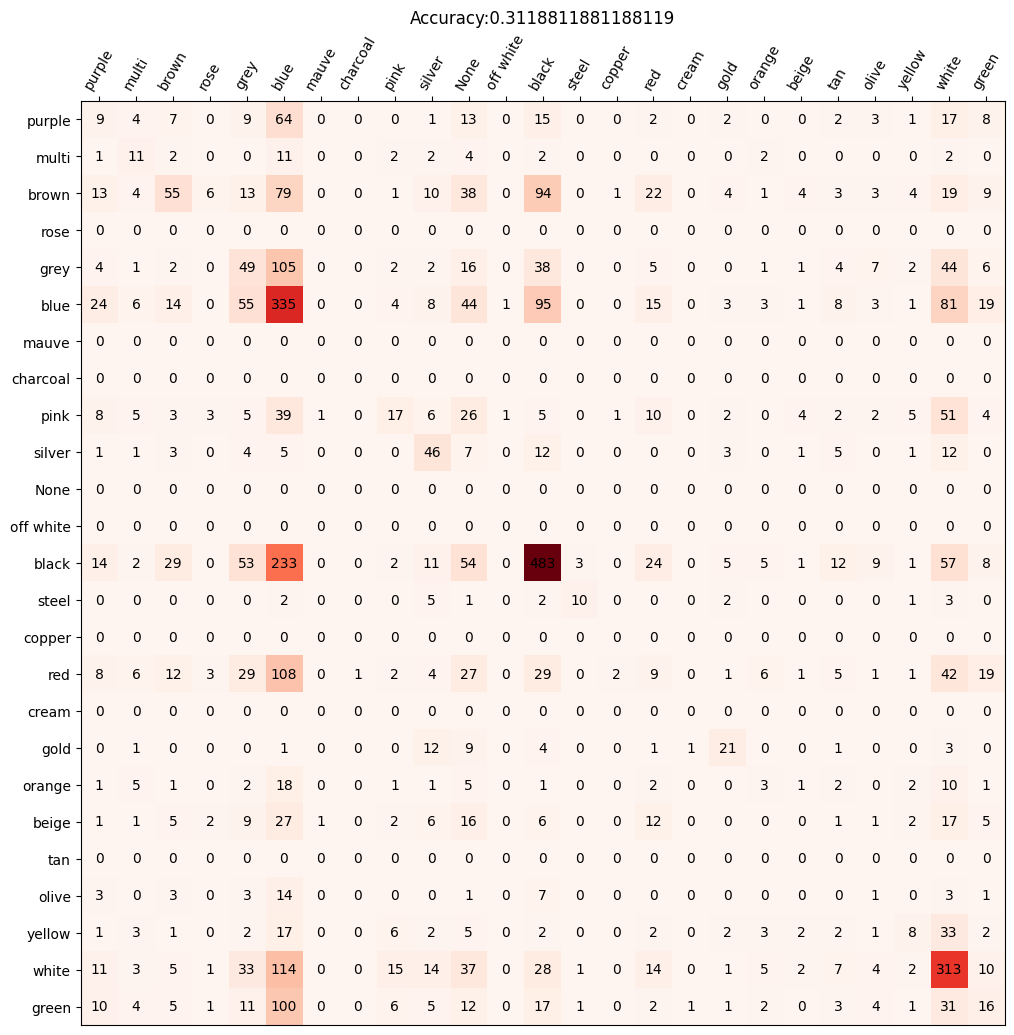

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
classes = list(set(true_colors+pred_colors))
cm = confusion_matrix(true_colors, pred_colors, classes)
np.save('data/confusionmatrix_color_validationset.npy',cm)
acc = accuracy_score(true_colors, pred_colors)
# cm_display = ConfusionMatrixDisplay(cm).plot()
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Reds'))
# plt.xticks(classes)
num_classes = len(classes)
for i in range(num_classes):
   for j in range(num_classes):
      c = cm[j,i]
      ax.text(i,j,str(c),va='center',ha='center')
    
ax.set_xticks(list(range(num_classes)))
ax.xaxis.set_ticks_position('top') 
ax.set_xticklabels(classes, rotation=60)
ax.set_yticks(list(range(num_classes)))
ax.set_yticklabels(classes)
plt.title(f'Accuracy:{acc}')
plt.show()

In [ ]:
np.save('data/confusionmatrix_color_1_epoch44.npy',cm)

In [18]:
import pickle
import os
import numpy as np
loss_list = []
acc_list = []
try_num = 1
paths = os.listdir(f'track/{try_num}/')
acc_paths = [p for p in paths if 'acc' in p]
loss_paths = [p for p in paths if 'loss' in p]
# loss_paths = [loss_paths[4],loss_paths[5],loss_paths[0],loss_paths[6],loss_paths[8],loss_paths[7],loss_paths[2],loss_paths[9],loss_paths[3],loss_paths[1]]
# acc_paths = [acc_paths[0],acc_paths[6],acc_paths[1],acc_paths[5],acc_paths[7],acc_paths[9],acc_paths[3],acc_paths[8],acc_paths[4],acc_paths[2]]
acc_paths.sort(key=lambda s:int(s.split('_')[-2]))
loss_paths.sort(key=lambda s:int(s.split('_')[-2]))

# with open('data/fashion-dataset/validation_set.pkl', 'rb') as f:
#     validation_set = pickle.load(f)

In [19]:
ave_loss_list = []
ave_acc_list = []
for p in loss_paths:    
    with open(f'track/{try_num}/{p}', 'rb') as f:
        ll = pickle.load(f)
        loss_list += ll
        a = np.mean(ll)
        print(f'ave loss:{a}')
        ave_loss_list.append(a)
for p in acc_paths:    
    with open(f'track/{try_num}/{p}', 'rb') as f:
        al = pickle.load(f)
        acc_list += al
        a = np.mean(al)
        print(f'ave acc:{a}')
        ave_acc_list.append(a)

ave loss:3.121114555100342
ave loss:2.0624364686331913
ave loss:1.8271586878777752
ave loss:1.6637797364261664
ave loss:1.5438325879838912
ave loss:1.4574660203789496
ave loss:1.390514534312147
ave loss:1.3627919198523482
ave loss:1.2825398377408825
ave loss:1.2422446173400103
ave loss:1.2338415147465722
ave loss:1.159577720458163
ave loss:1.1344168721758994
ave loss:1.1008283755066286
ave loss:1.0884898637483735
ave loss:1.0655365452433798
ave loss:1.0345877982364649
ave loss:1.0155212079320366
ave loss:1.0042771167740923
ave loss:0.9252342401495948
ave loss:0.8631263891111962
ave loss:0.8561727694031019
ave loss:0.8318487852157106
ave loss:0.8164595042397385
ave loss:0.8171371826235793
ave loss:1.003854184032894
ave loss:0.9430008252868466
ave loss:0.9407197914469616
ave loss:0.9130332848033179
ave loss:0.8845894855642433
ave loss:0.8684149546618274
ave loss:0.8751507904318699
ave loss:0.8499280269942923
ave loss:0.8312905020527901
ave loss:0.894143487292082
ave loss:0.82656422584221

In [5]:
import pickle
with open(f'track/1/validation_acc.pkl', 'rb') as f:
    n = pickle.load(f)

In [6]:
n

[0.3598278985507246,
 0.4633152173913043,
 0.5176630434782609,
 0.5276268115942029,
 0.5407608695652174,
 0.5595561594202898,
 0.5760869565217391,
 0.5885416666666666,
 0.5901268115942029,
 0.5717844202898551,
 0.6043931159420289,
 0.6032608695652174,
 0.6100543478260869]

In [ ]:
plt.figure()
plt.plot(gaussian_filter1d(acc_list, sigma=1001))
plt.title('Accuracy Curve')
plt.xlabel('Batches of Samples')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
plt.figure()
plt.plot(np.log2(gaussian_filter1d(loss_list,sigma=1000)+1))
plt.title('Loss Curve')
plt.xlabel('Batches of Samples')
plt.ylabel('Loss (With Log2)')
plt.show()

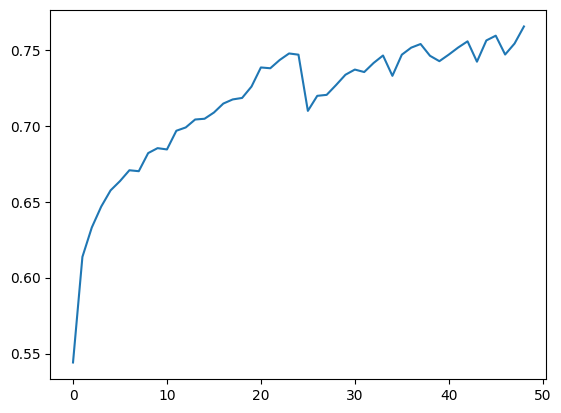

In [20]:
plt.figure()
plt.plot(ave_acc_list)
plt.show()

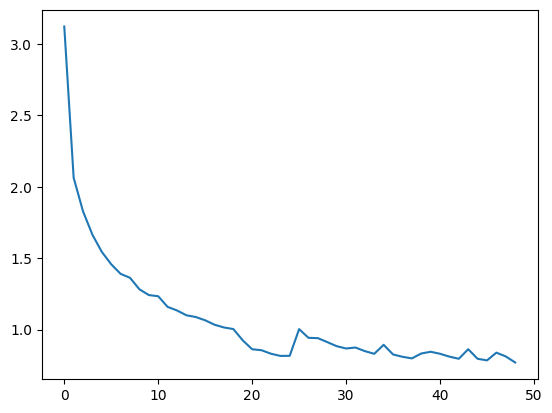

In [21]:
plt.figure()
plt.plot(ave_loss_list)
plt.show()

In [ ]:
torch.cuda.memory_allocated(device)/1024/1024/1024